In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv
/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_score, recall_score, jaccard_score, roc_curve, RocCurveDisplay, log_loss, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, cross_validate, RepeatedKFold
from lightgbm import LGBMRegressor 
from xgboost import XGBRegressor ,XGBClassifier
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
import catboost as cat
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
import shap
from imblearn.over_sampling import SMOTE

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")
sub=pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")
original = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')

In [4]:
sum(original.duplicated())
original=original.drop_duplicates()

In [5]:
train = train.drop(columns=['id'], axis=1)
original =original[train.columns]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.4+ MB


In [7]:
original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           31529 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  int64  
 7   loan_int_rate               29321 non-null  float64
 8   loan_percent_income         32416 non-null  float64
 9   cb_person_default_on_file   32416 non-null  object 
 10  cb_person_cred_hist_length  32416 non-null  int64  
 11  loan_status                 32416 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


In [8]:
original['loan_int_rate'] = original['loan_int_rate'].fillna(0)
original['person_emp_length'] = original['person_emp_length'].fillna(0)

In [9]:
original.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,32416.000000,3.241600e+04,32416.000000,32416.000000,32416.000000,32416.000000,32416.000000,32416.000000
mean,27.747008,6.609164e+04,4.659427,9593.845632,9.965364,0.170250,5.811297,0.218688
std,6.354100,6.201558e+04,4.162406,6322.730241,4.470799,0.106812,4.059030,0.413363
min,20.000000,4.000000e+03,0.000000,500.000000,0.000000,0.000000,2.000000,0.000000
25%,23.000000,3.854200e+04,2.000000,5000.000000,7.490000,0.090000,3.000000,0.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.620000,0.150000,4.000000,0.000000
75%,30.000000,7.921800e+04,7.000000,12250.000000,13.110000,0.230000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [10]:
train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [11]:
train = pd.concat([train, original])

In [12]:
sum(train.duplicated())

0

In [13]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [14]:
test_v2 = test.drop(columns='id', axis=1)
original_v2 = original.drop(columns='loan_status', axis=1)
original_test = pd.concat([test_v2, original_v2])
sum(original_test.duplicated())


1

In [15]:
original_test[original_test.duplicated()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
2845,23,60000,RENT,1.0,DEBTCONSOLIDATION,A,3000,7.51,0.05,N,2


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91061 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91061 non-null  int64  
 1   person_income               91061 non-null  int64  
 2   person_home_ownership       91061 non-null  object 
 3   person_emp_length           91061 non-null  float64
 4   loan_intent                 91061 non-null  object 
 5   loan_grade                  91061 non-null  object 
 6   loan_amnt                   91061 non-null  int64  
 7   loan_int_rate               91061 non-null  float64
 8   loan_percent_income         91061 non-null  float64
 9   cb_person_default_on_file   91061 non-null  object 
 10  cb_person_cred_hist_length  91061 non-null  int64  
 11  loan_status                 91061 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


In [17]:
print(sum(train.duplicated())) #check for duplicates
train.drop_duplicates(inplace=True) #Drop dublicates

0


In [18]:
100* train.isnull().sum() / train.shape[0] #bunu bi kontrol et

person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
loan_status                   0.0
dtype: float64

In [19]:
train[train['person_emp_length'].isnull()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status


In [20]:
100* test.isnull().sum() / test.shape[0]

id                            0.0
person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
dtype: float64

In [21]:
columns = train.columns
unique_values = {col: train[col].nunique() for col in columns} #Find number of unique values in each columns
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")

person_age: 58 unique values
person_income: 4376 unique values
person_home_ownership: 4 unique values
person_emp_length: 38 unique values
loan_intent: 6 unique values
loan_grade: 7 unique values
loan_amnt: 759 unique values
loan_int_rate: 389 unique values
loan_percent_income: 78 unique values
cb_person_default_on_file: 2 unique values
cb_person_cred_hist_length: 29 unique values
loan_status: 2 unique values


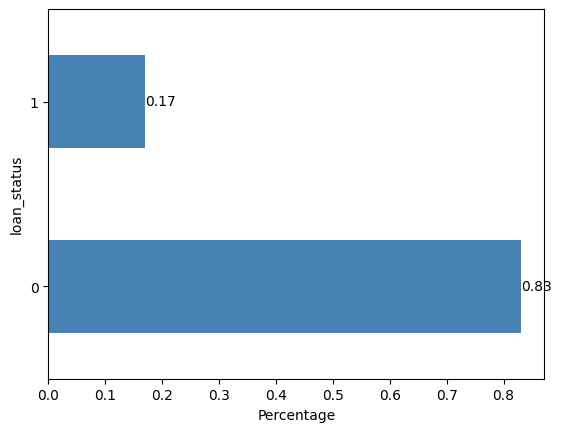

In [22]:
ax = round(train['loan_status'].value_counts(normalize=True), 2).plot(kind='barh', color='steelblue')
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
plt.xlabel('Percentage');

In [23]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def pre_process_train(X):
    label_encoders = {}
    
    # Identify numerical columns
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    
    # Scale all numerical columns at once
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    
    # Encode categorical columns
    for col in X.select_dtypes(include=['object']).columns:
        #le = LabelEncoder()
        #X[col] = le.fit_transform(X[col])
        #label_encoders[col] = le  # Store the label encoders for future use
        X[col] = X[col].astype('category')
    
    return X, scaler, label_encoders

def pre_process_test(X_test, scaler, label_encoders):
    # Ensure the test set has the same columns in the same order as the train set
    #X_test = X_test.reindex(columns=X_train_columns, fill_value=0)
    
    # Identify numerical columns
    numerical_cols = X_test.select_dtypes(include=['int64', 'float64']).columns
    
    # Scale all numerical columns using the previously fitted scaler
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
    
    # Encode categorical columns using the previously fitted label encoders
    for col in X_test.select_dtypes(include=['object']).columns:
        #if col in label_encoders:  # Ensure that the column was encoded in training
            #le = label_encoders[col]
            #X_test[col] = le.transform(X_test[col])
        X_test[col] = X_test[col].astype('category')
    
    return X_test



In [24]:
train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,91061.000000,9.106100e+04,91061.000000,91061.000000,91061.000000,91061.000000,91061.000000,91061.000000
mean,27.620683,6.477432e+04,4.686210,9351.508352,10.424234,0.163158,5.812752,0.169546
std,6.150047,4.792286e+04,4.033107,5848.017127,3.628029,0.097486,4.039820,0.375235
min,20.000000,4.000000e+03,0.000000,500.000000,0.000000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.660000,0.090000,3.000000,0.000000
50%,26.000000,5.700000e+04,4.000000,8000.000000,10.740000,0.140000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.040000,0.220000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [25]:
train[train['person_age'] > 99]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
47336,123,36000,MORTGAGE,7.0,PERSONAL,B,6700,10.75,0.18,N,4,0
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0.02,N,3,0
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0.03,N,2,0
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0.25,N,3,0
747,123,78000,RENT,7.0,VENTURE,B,20000,0.00,0.26,N,4,0
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0.00,N,25,0


In [26]:
def new_features(X):
    train = X.copy()
    train["loantoincome"] = (train["loan_amnt"] / train["person_income"]) - train["loan_percent_income"]
    #train['loan_to_emp_length_ratio'] = train['person_emp_length'] / train['loan_amnt'] negative impact
    train['abs_income'] = train['person_income'] - train["loan_amnt"] * (1 + train["loan_int_rate"])   # negative impact
    return train
    

In [27]:
train = new_features(train)
test = new_features(test)

In [28]:
ids= test['id']
X = train.drop(columns=['loan_status'], axis=1)
y = train.loan_status
# Pre-process the training data
X, scaler, label_encoders = pre_process_train(X)
# Pre-process the test data using the scaler and label encoders from training
test = test.drop('id', axis=1)
test = pre_process_test(test, scaler, label_encoders)


In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91061 entries, 0 to 32580
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  91061 non-null  float64 
 1   person_income               91061 non-null  float64 
 2   person_home_ownership       91061 non-null  category
 3   person_emp_length           91061 non-null  float64 
 4   loan_intent                 91061 non-null  category
 5   loan_grade                  91061 non-null  category
 6   loan_amnt                   91061 non-null  float64 
 7   loan_int_rate               91061 non-null  float64 
 8   loan_percent_income         91061 non-null  float64 
 9   cb_person_default_on_file   91061 non-null  category
 10  cb_person_cred_hist_length  91061 non-null  float64 
 11  loantoincome                91061 non-null  float64 
 12  abs_income                  91061 non-null  float64 
dtypes: category(4), float

In [30]:
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

In [31]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = ['f1',  'roc_auc', 'average_precision', 'precision', 'recall', 'jaccard']

# Initialize XGBoost classifier
xgb_model = XGBClassifier(enable_categorical = True)
# Perform cross-validation
xgb_cv_scores = cross_validate(xgb_model, X, y, cv=skf, scoring=scores)

# Print the cross-validation accuracy scores
for score in scores:
    print(f"XGBoost CV {score} Scores: {xgb_cv_scores['test_' + score]}")
    print(f"XGBoost Mean CV {score}: {xgb_cv_scores['test_' + score].mean()}")

XGBoost CV f1 Scores: [0.82707847 0.82734981 0.82820651 0.84315471 0.82352941]
XGBoost Mean CV f1: 0.8298637826641772
XGBoost CV roc_auc Scores: [0.95382472 0.95488394 0.95745841 0.96099589 0.95750937]
XGBoost Mean CV roc_auc: 0.9569344670721819
XGBoost CV average_precision Scores: [0.89099236 0.89135462 0.89821375 0.9014566  0.89249529]
XGBoost Mean CV average_precision: 0.8949025212579087
XGBoost CV precision Scores: [0.92825474 0.93363192 0.93160664 0.93633847 0.92282958]
XGBoost Mean CV precision: 0.9305322701010639
XGBoost CV recall Scores: [0.74579016 0.74279236 0.74546632 0.76683938 0.74352332]
XGBoost Mean CV recall: 0.7488823052043418
XGBoost CV jaccard Scores: [0.70514391 0.70553846 0.70678539 0.72883964 0.7       ]
XGBoost Mean CV jaccard: 0.7092614793498452


In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  39098 non-null  float64 
 1   person_income               39098 non-null  float64 
 2   person_home_ownership       39098 non-null  category
 3   person_emp_length           39098 non-null  float64 
 4   loan_intent                 39098 non-null  category
 5   loan_grade                  39098 non-null  category
 6   loan_amnt                   39098 non-null  float64 
 7   loan_int_rate               39098 non-null  float64 
 8   loan_percent_income         39098 non-null  float64 
 9   cb_person_default_on_file   39098 non-null  category
 10  cb_person_cred_hist_length  39098 non-null  float64 
 11  loantoincome                39098 non-null  float64 
 12  abs_income                  39098 non-null  float64 
dtypes: category(4), 

In [33]:

xgb_m = XGBClassifier(enable_categorical = True) 
xgb_m.fit(X, y)
y_pred_xgb = xgb_m.predict_proba(test)[:, 1]
results_df_xgb = pd.DataFrame({
    'id': ids,
    'loan_status': y_pred_xgb
})
results_df_xgb.to_csv('baseline_sub_0_xgb.csv', index=False)

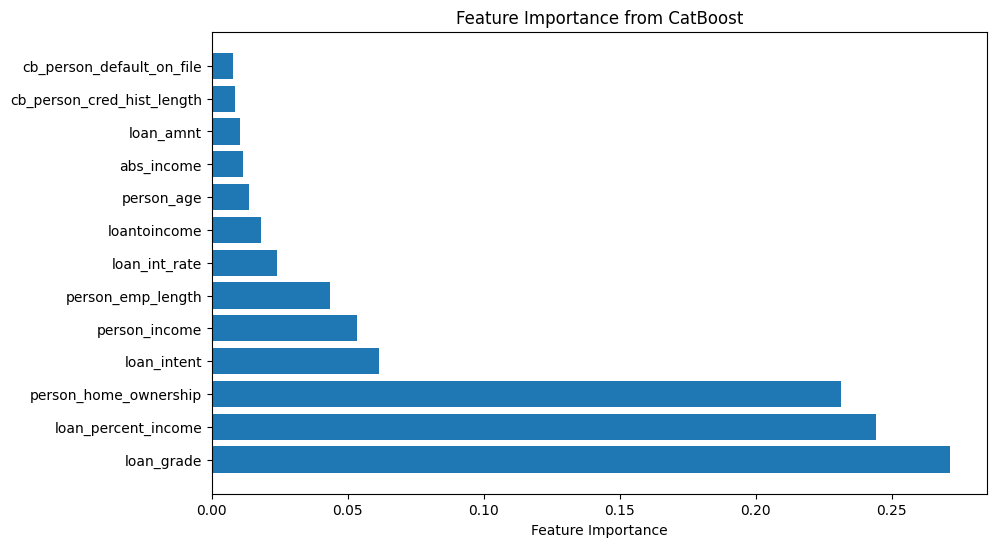

In [34]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_m.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from CatBoost')
plt.show()

In [35]:
y_pred_xgb

array([0.99972254, 0.04360015, 0.39342758, ..., 0.00371636, 0.14875807,
       0.9571786 ], dtype=float32)

In [36]:
lgbm_m = lgb.LGBMClassifier()
lgbm_m.fit(X, y)
y_pred_xgb = lgbm_m.predict_proba(test)[:, 1]
results_df_xgb = pd.DataFrame({
    'id': ids,
    'loan_status': y_pred_xgb
})
results_df_xgb.to_csv('baseline_sub_0_lgbm.csv', index=False)

[LightGBM] [Info] Number of positive: 15439, number of negative: 75622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1462
[LightGBM] [Info] Number of data points in the train set: 91061, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169546 -> initscore=-1.588850
[LightGBM] [Info] Start training from score -1.588850


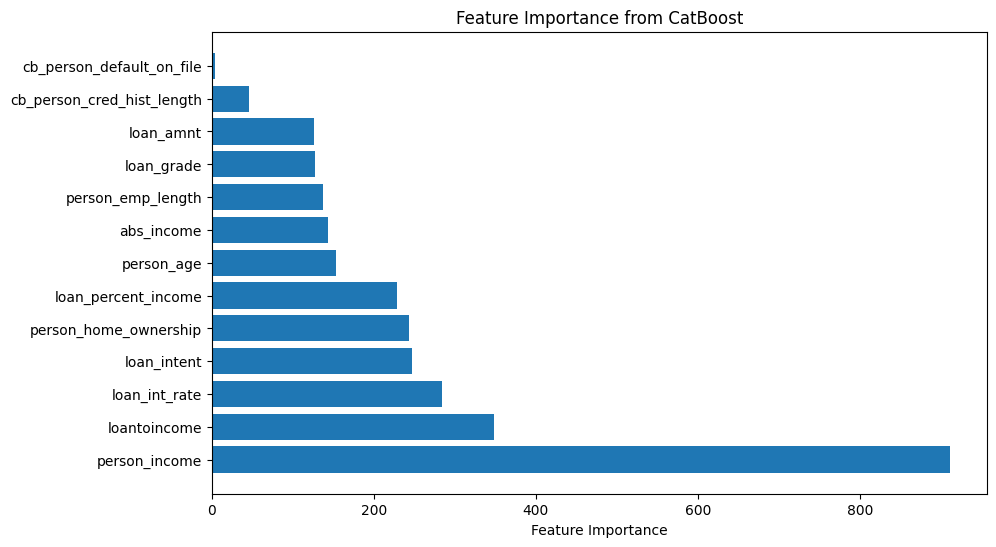

In [37]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgbm_m.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from CatBoost')
plt.show()

In [38]:
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC'}

cat_columns = X.select_dtypes(include=['category']).columns.tolist()
cat_m = cat.CatBoostClassifier()
cat_m.fit(X, y, cat_features=cat_columns)
y_pred_xgb = cat_m.predict_proba(test)[:, 1]
results_df_xgb = pd.DataFrame({
    'id': ids,
    'loan_status': y_pred_xgb
})
results_df_xgb.to_csv('baseline_sub_0_cat.csv', index=False)

Learning rate set to 0.070724
0:	learn: 0.6141696	total: 128ms	remaining: 2m 7s
1:	learn: 0.5516200	total: 188ms	remaining: 1m 33s
2:	learn: 0.5011571	total: 255ms	remaining: 1m 24s
3:	learn: 0.4573751	total: 319ms	remaining: 1m 19s
4:	learn: 0.4227401	total: 379ms	remaining: 1m 15s
5:	learn: 0.3899895	total: 441ms	remaining: 1m 13s
6:	learn: 0.3629220	total: 503ms	remaining: 1m 11s
7:	learn: 0.3382720	total: 557ms	remaining: 1m 9s
8:	learn: 0.3188738	total: 611ms	remaining: 1m 7s
9:	learn: 0.3024495	total: 661ms	remaining: 1m 5s
10:	learn: 0.2899030	total: 717ms	remaining: 1m 4s
11:	learn: 0.2783044	total: 767ms	remaining: 1m 3s
12:	learn: 0.2682517	total: 820ms	remaining: 1m 2s
13:	learn: 0.2584886	total: 872ms	remaining: 1m 1s
14:	learn: 0.2503351	total: 920ms	remaining: 1m
15:	learn: 0.2439025	total: 977ms	remaining: 1m
16:	learn: 0.2380793	total: 1.03s	remaining: 59.8s
17:	learn: 0.2335932	total: 1.09s	remaining: 59.5s
18:	learn: 0.2295389	total: 1.14s	remaining: 58.9s
19:	learn: 

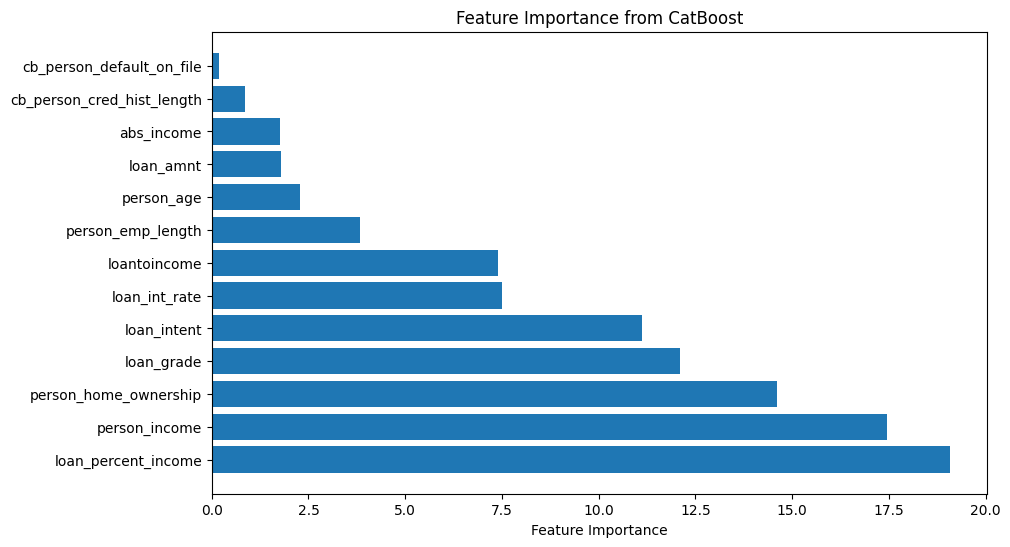

In [39]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': cat_m.get_feature_importance()
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from CatBoost')
plt.show()